### Importing the necessary libraries

In [280]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import datetime as dt
from statsmodels.tsa.stattools import adfuller
import io
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.api import Holt,ExponentialSmoothing

### Importing Dataset

In [281]:
df_gold=pd.read_csv(r'C:\Users\surya\Downloads\GCF_2008.csv') #incase this doesnt work upload the database you have. and change file addr

In [282]:
df_gold.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 627 entries, 0 to 626
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       627 non-null    object 
 1   Open       627 non-null    float64
 2   High       627 non-null    float64
 3   Low        627 non-null    float64
 4   Close      627 non-null    float64
 5   Adj Close  627 non-null    float64
 6   Volume     627 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 34.4+ KB


In [283]:
df_gold.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2008-08-11,826.400024,831.900024,780.900024,786.000000,786.000000,455
1,2008-08-18,792.000000,836.599976,789.599976,827.400024,827.400024,277
2,2008-08-25,819.799988,842.599976,819.799988,829.299988,829.299988,1228
3,2008-09-01,829.900024,840.700012,790.799988,797.599976,797.599976,374
4,2008-09-08,811.000000,813.200012,739.000000,760.299988,760.299988,210


In [284]:
df_gold.head()
df_gold[df_gold.isnull()]#No NaN values in dataset

,Date,Open,High,Low,Close,Adj Close,Volume
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
622,NaN,NaN,NaN,NaN,NaN,NaN,NaN
623,NaN,NaN,NaN,NaN,NaN,NaN,NaN
624,NaN,NaN,NaN,NaN,NaN,NaN,NaN
625,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [285]:
df_gold.dtypes# We have to convert date to Datetime object

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [286]:
df_gold.Date=pd.to_datetime(df_gold.Date)

In [287]:
df_gold.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object

In [288]:
df_gold.index=df_gold.Date #indexing dataframe by date

In [289]:
df_gold.drop('Date',inplace=True,axis=1)

In [290]:
df_gold.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2008-08-11,826.400024,831.900024,780.900024,786.000000,786.000000,455
2008-08-18,792.000000,836.599976,789.599976,827.400024,827.400024,277
2008-08-25,819.799988,842.599976,819.799988,829.299988,829.299988,1228
2008-09-01,829.900024,840.700012,790.799988,797.599976,797.599976,374
2008-09-08,811.000000,813.200012,739.000000,760.299988,760.299988,210


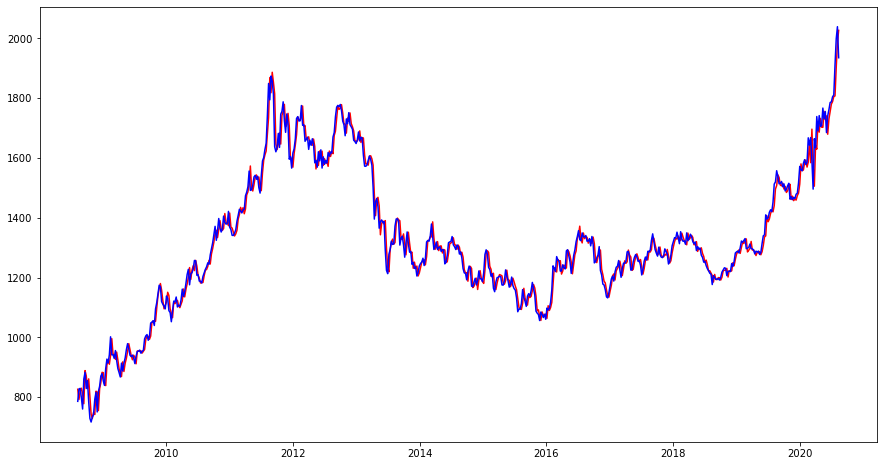

In [291]:
fig=plt.figure(figsize=(15,8))
plt.plot(df_gold.Open,color='red')
plt.plot(df_gold.Close,color='blue')

### Testing Stationary

#### Using moving average

Test Statistic                  -0.988662
p-value                          0.757377
#Lags Used                       0.000000
Number of Observations Used    626.000000
Critical Value (1%)             -3.440839
Critical Value (5%)             -2.866168
Critical Value (10%)            -2.569235
dtype: float64


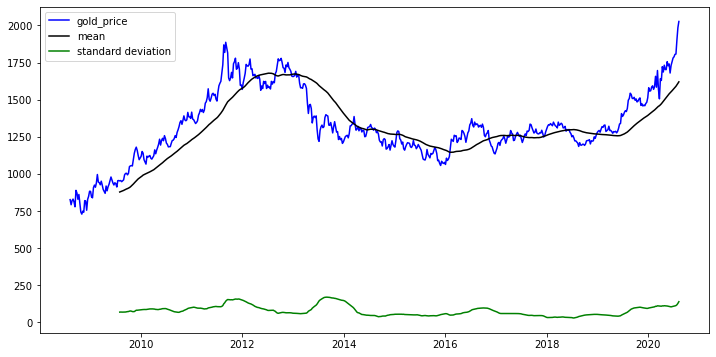

In [292]:
def check_stationary(df_):
    rollingmean=df_.rolling(52).mean() #taking mean of 52 weeks gold price(one year)
    rollingstd=df_.rolling(52).std()
    plt.figure(figsize=(12,6))
    plt.plot(df_,color='blue',label='gold_price')
    plt.plot(rollingmean,color='black',label='mean')
    plt.plot(rollingstd,color='green',label='standard deviation') #Laude ka stationary hai ye toh
    plt.legend(loc='best')
    dftest=adfuller(df_,autolag='AIC')
    df_test=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    df_test
    for key,value in dftest[4].items():
        df_test['Critical Value (%s)'%key] = value
    print(df_test)

check_stationary(df_gold.Open)

Refer-https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/

### Making Series Stationary

Test Statistic                  -2.564911
p-value                          0.100468
#Lags Used                       0.000000
Number of Observations Used    575.000000
Critical Value (1%)             -3.441774
Critical Value (5%)             -2.866580
Critical Value (10%)            -2.569454
dtype: float64


<Figure size 864x432 with 0 Axes>

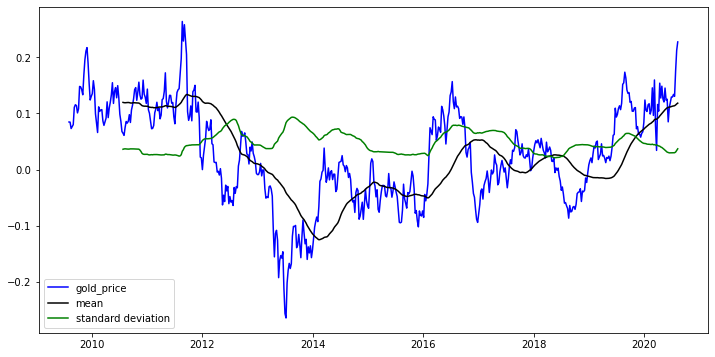

In [293]:
price_log=np.log(df_gold.Open)
moving_average=price_log.rolling(52).mean()
moving_diff=price_log-moving_average
plt.figure(figsize=(12,6))

moving_diff.dropna(inplace=True)
check_stationary(moving_diff)


Test Statistic                 -25.883764
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    625.000000
Critical Value (1%)             -3.440856
Critical Value (5%)             -2.866175
Critical Value (10%)            -2.569239
dtype: float64


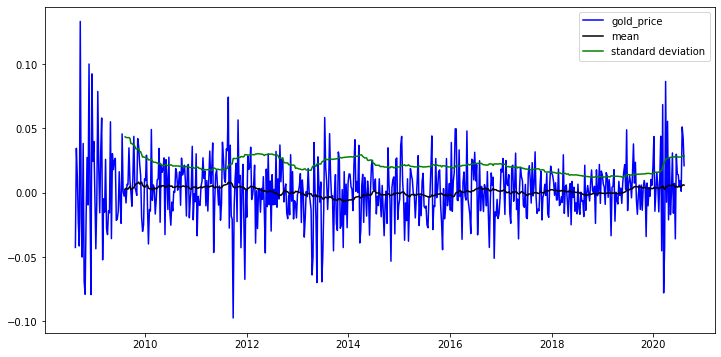

In [294]:
moving_diff_shift=price_log-price_log.shift()
moving_diff_shift =moving_diff_shift.dropna()    #STABILIZING THE MEAN
check_stationary(moving_diff_shift)


In [295]:

# exp_average=price_log.ewm(span=52).mean()


# exp_diff=price_log-exp_average
# exp_diff_shift = exp_diff - exp_diff.shift()    #exp_diff_shift
# exp_diff_shift=exp_diff_shift.dropna()

# exp_diff.dropna(inplace=True)
# check_stationary(exp_diff_shift)



### Decomposing

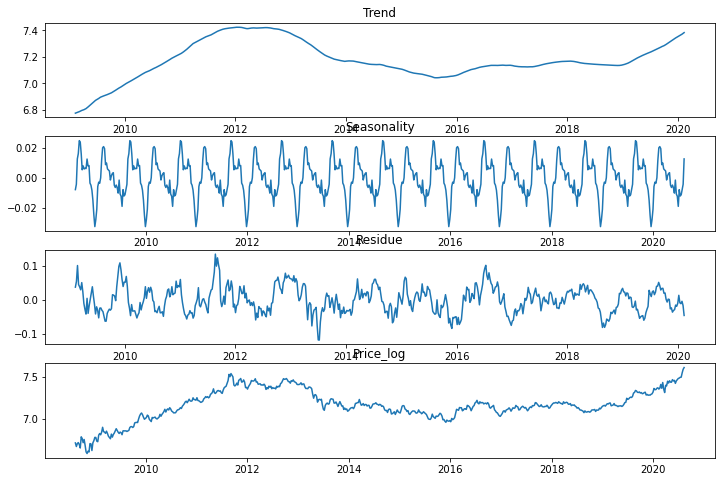

In [296]:
decomposition=seasonal_decompose(price_log) 
trend=decomposition.trend
seasonality=decomposition.seasonal
residure=decomposition.resid
plt.figure(figsize=(12,8))
plt.subplot(4,1,1)
plt.title('Trend')
plt.plot(trend)
plt.subplot(4,1,2)
plt.title('Seasonality')
plt.plot(seasonality)
plt.subplot(4,1,3)
plt.title('Residue')
plt.plot(residure)
plt.subplot(4,1,4)
plt.title('Price_log')
plt.plot(price_log)
residure.dropna(inplace=True)
seasonality.dropna(inplace=True)
trend.dropna(inplace=True)

Test Statistic                -6.743207e+00
p-value                        3.081258e-09
#Lags Used                     1.000000e+00
Number of Observations Used    5.730000e+02
Critical Value (1%)           -3.441814e+00
Critical Value (5%)           -2.866597e+00
Critical Value (10%)          -2.569463e+00
dtype: float64


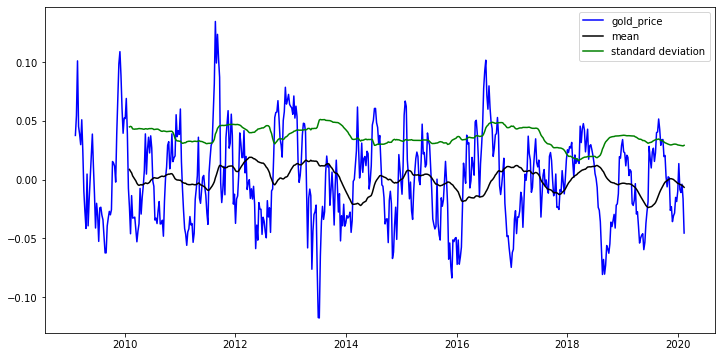

In [297]:
check_stationary(residure)

### Using decompose to remove trend and seasonality.

C:\Users\surya\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


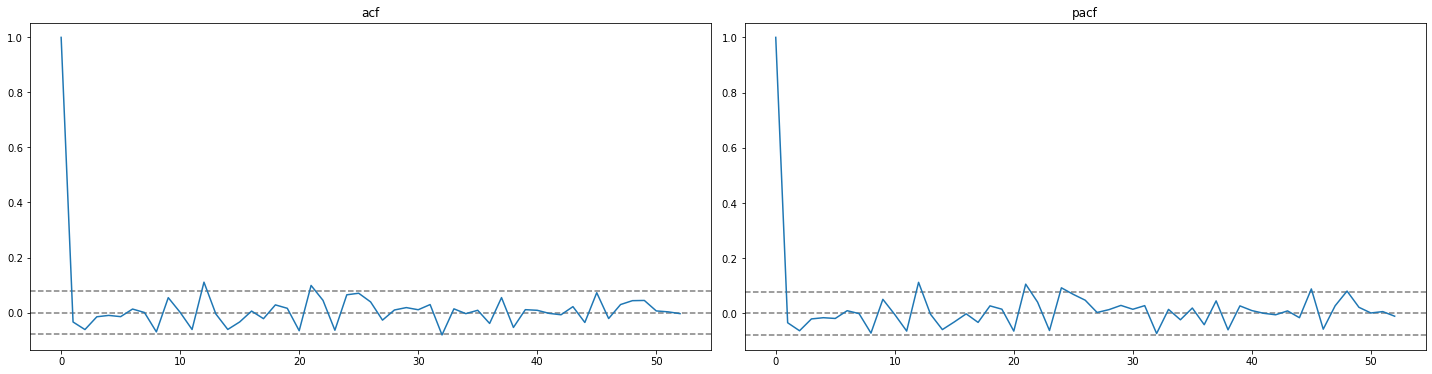

In [298]:
lag_acf=acf(moving_diff_shift,nlags=52)                 #Used this instead of exp
lag_pacf=pacf(moving_diff_shift,nlags=52,method='ols')
plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
plt.title('acf')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(moving_diff_shift)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(moving_diff_shift)),linestyle='--',color='gray')
plt.plot(lag_acf)

plt.subplot(2,2,2)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(moving_diff_shift)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(moving_diff_shift)),linestyle='--',color='gray')
plt.title('pacf')
plt.plot(lag_pacf)
plt.tight_layout() #AR(2)  to be used(refer link below)

### ARIMA

C:\Users\surya\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  % freq, ValueWarning)
C:\Users\surya\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS 0.3753')

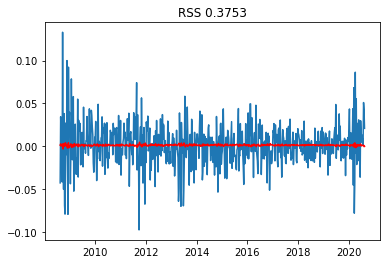

In [299]:
arima_pred=ARIMA(price_log,order=(1,1,0))   #changed the values from 2,0,0 
result_fit=arima_pred.fit()  #disp=-1
plt.plot(moving_diff_shift)
plt.plot(result_fit.fittedvalues,color='red')
plt.title('RSS %.4f'% sum((result_fit.fittedvalues+moving_diff_shift)**2))

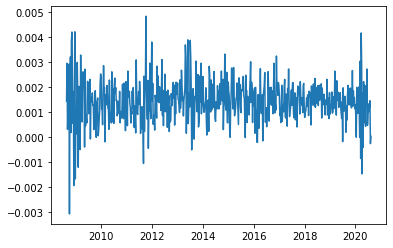

In [300]:
plt.plot(result_fit.fittedvalues)


In [301]:
result_fit.fittedvalues.tail()

Date
2020-07-13    0.001322
2020-07-20    0.001162
2020-07-27    0.001445
2020-08-03   -0.000271
2020-08-10    0.000023
dtype: float64

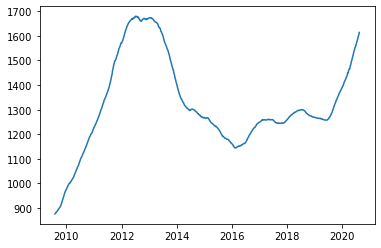

In [302]:
pred_diff=pd.Series(result_fit.fittedvalues,copy=True)

plt.plot(np.exp(pred_diff+moving_average))  #used moving_avg


In [303]:

pred_diff_cs=pred_diff.cumsum()                            
pred_log_base=pd.Series(price_log.iloc[0],index=price_log.index)
pred_log_base=pred_log_base.add(pred_diff_cs,fill_value=0)
pred_final=np.exp(pred_log_base)
series1=pred_final
series1.tail()


Date
2020-07-13    2024.672304
2020-07-20    2027.026702
2020-07-27    2029.958515
2020-08-03    2029.408368
2020-08-10    2029.455097
dtype: float64

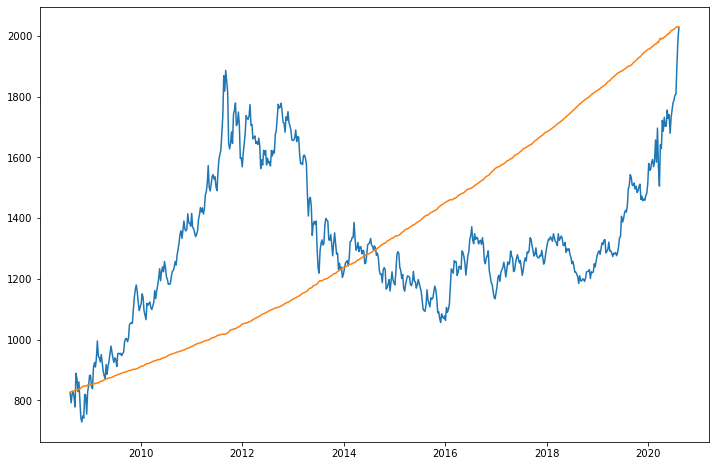

In [304]:
plt.figure(figsize=(12,8))
plt.plot(df_gold.Open)
plt.plot(series1)

### Forecasting

In [305]:
# nolog= ARIMA(df_gold.Open,order=(1,1,0))   #This was solely done to access the graph with the actual values of the y-axis
# ogscale=nolog.fit()
# og=ogscale.plot_predict(500,700)

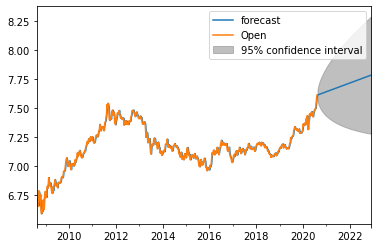

In [306]:

x=result_fit.plot_predict(1,747)


C:\Users\surya\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


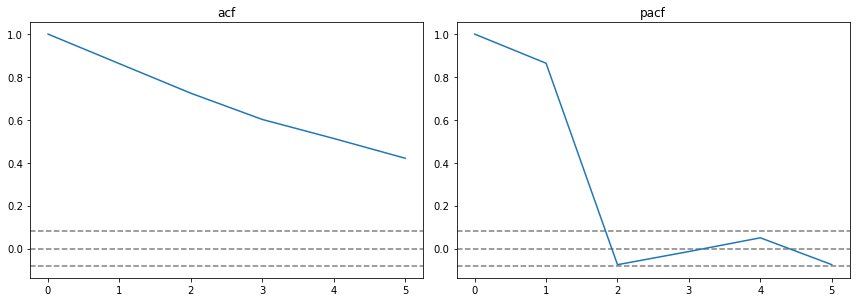

In [307]:
lag_acf=acf(residure.dropna(),nlags=5)                 #Used this instead of exp
lag_pacf=pacf(residure.dropna(),nlags=5,method='ols')
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plt.title('acf')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(residure)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(residure)),linestyle='--',color='gray')
plt.plot(lag_acf)

plt.subplot(2,2,2)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(residure)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(residure)),linestyle='--',color='gray')
plt.title('pacf')
plt.plot(lag_pacf)
plt.tight_layout() #AR(2)  to be used(refer link below)

In [308]:
arima_pred=ARIMA(residure.dropna(),order=(1,0,0))  
result_fit=arima_pred.fit(disp=-1)  #disp=-1



C:\Users\surya\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  % freq, ValueWarning)


False    575
True      52
dtype: int64

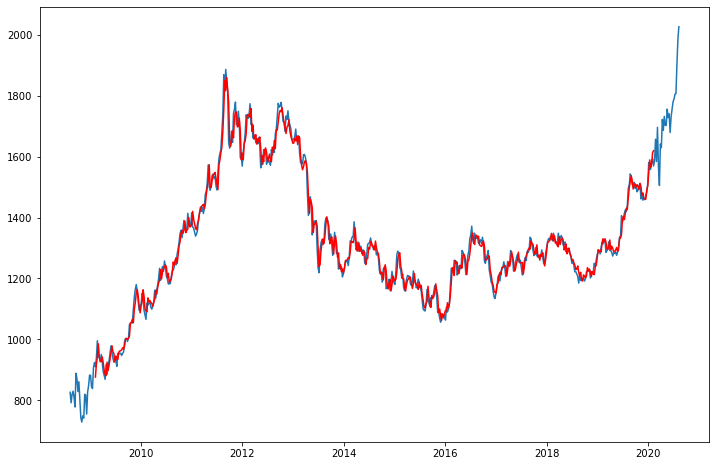

In [309]:

series_final=result_fit.fittedvalues+trend+seasonality

result_final=np.exp(series_final)
plt.figure(figsize=(12,8))
plt.plot(df_gold.Open)
plt.plot(result_final,color='red')
result_final.isnull().value_counts()

### Calculating Error

In [310]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mean_absolute_percentage_error(df_gold.Open,pred_final)

23.251821345433456